In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, norm
from scipy.integrate import quad

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import tree

# Taken from Richard's "Reprod Figure 2"

In [3]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

# def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
#     model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
#                               n_estimators = n_estimators, 
#                               max_samples= max_samples, 
#                               bootstrap = bootstrap)
#     model.fit(X, y)
#     class_counts = np.zeros((X.shape[0], model.n_classes_))
#     for idx, tree in enumerate(model): # RONAK EDIT
#         # get out of bag indicies
        
#         # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
#         #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
#         sampled_indices = model.estimators_samples_[idx]
#         unsampled_indices = np.delete(np.arange(0, len(X)), sampled_indices)
        
#         # RONAK EDIT ENDS HERE ##################
        
#         total_unsampled = len(unsampled_indices)
#         np.random.shuffle(unsampled_indices)
#         prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
#         # get all node counts
#         node_counts = tree.tree_.n_node_samples
#         # get probs for eval samples
#         posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
#         for prob_index in prob_indices:
#             posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
#         row_sums = posterior_class_counts.sum(axis=1)
#         row_sums[row_sums == 0] = 1
#         class_probs = (posterior_class_counts/row_sums[:, None])
        
#         where_0 = np.argwhere(class_probs == 0)
#         for elem in where_0:
#             class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
#         where_1 = np.argwhere(class_probs == 1)
#         for elem in where_1:
#             class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
#         class_probs.tolist()
#         partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
#         # get probability for out of bag samples
#         eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
#         eval_class_probs = np.array(eval_class_probs)
#         # find total elements for out of bag samples
#         elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
#         # store counts for each x (repeat fhis for each tree)
#         class_counts[eval_indices] += elems
#     # calculate p(y|X = x) for all x's
#     probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
#     entropies = -np.sum(np.log(probs)*probs, axis = 1)
#     # convert nan to 0
#     entropies = np.nan_to_num(entropies)
#     return np.mean(entropies)

# np.warnings.filterwarnings('ignore')

/home/ronak/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
def cef_estimate_mike_1(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    tree_idx = 0
    for tree in model:
        
        # get out of bag indices.       
        # Here's where we obtain unsampled indices.
        # unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X), int((1 - max_samples)*len(X)))
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,X.shape[0]), sampled_indices)
        tree_idx = tree_idx + 1
        # Done with unsampled indices.
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

In [5]:
# no weighting.
def cef_estimate2(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    estimate = 0.0
    for idx, tree in enumerate(model): # RONAK EDIT
        # get out of bag indicies
        
        # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
        #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        sampled_indices = model.estimators_samples_[idx]
        unsampled_indices = np.delete(np.arange(0, len(X)), sampled_indices)
        
        # RONAK EDIT ENDS HERE ##################
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
  
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        estimate += np.mean(np.nan_to_num(-np.sum(np.log(eval_class_probs)*eval_class_probs, axis = 1)))
        
    return estimate / n_estimators

np.warnings.filterwarnings('ignore')

In [6]:
# Subsample all overlaps.
# def cef_estimate3(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
#     model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
#                               n_estimators = n_estimators, 
#                               max_samples= max_samples, 
#                               bootstrap = bootstrap)
#     model.fit(X, y)
#     class_counts = np.zeros((X.shape[0], model.n_classes_))
#     estimate = 0.0
#     for idx, tree in enumerate(model): # RONAK EDIT
#         # get out of bag indicies
        
#         # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
#         #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
#         sampled_indices = model.estimators_samples_[idx]
#         unsampled_indices = np.delete(np.arange(0, len(X)), sampled_indices)
        
#         # RONAK EDIT ENDS HERE ##################
        
#         total_unsampled = len(unsampled_indices)
#         np.random.shuffle(unsampled_indices)
#         prob_indices = np.random.choice(np.arange(len(X)), size=int(np.floor(0.67 * len(X))))
#         eval_indices = np.random.choice(np.arange(len(X)), size=int(np.floor(0.67 * len(X))))
#         # get all node counts
#         node_counts = tree.tree_.n_node_samples
#         # get probs for eval samples
#         posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
#         for prob_index in prob_indices:
#             posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
#         row_sums = posterior_class_counts.sum(axis=1)
#         row_sums[row_sums == 0] = 1
#         class_probs = (posterior_class_counts/row_sums[:, None])
        
#         where_0 = np.argwhere(class_probs == 0)
#         for elem in where_0:
#             class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
#         where_1 = np.argwhere(class_probs == 1)
#         for elem in where_1:
#             class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
#         class_probs.tolist()
#         eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
#         estimate += np.mean(np.nan_to_num(-np.sum(np.log(eval_class_probs)*eval_class_probs, axis = 1)))
    
#     return estimate / n_estimators

# np.warnings.filterwarnings('ignore')

In [7]:
# All?
# def cef_estimate4(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
#     model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
#                               n_estimators = n_estimators, 
#                               max_samples= max_samples, 
#                               bootstrap = bootstrap)
#     model.fit(X, y)
#     class_counts = np.zeros((X.shape[0], model.n_classes_))
#     estimate = 0.0
#     for idx, tree in enumerate(model): # RONAK EDIT
#         # get out of bag indicies
        
#         # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
#         #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
#         sampled_indices = model.estimators_samples_[idx]
#         unsampled_indices = np.delete(np.arange(0, len(X)), sampled_indices)
        
#         # RONAK EDIT ENDS HERE ##################
        
#         total_unsampled = len(unsampled_indices)
#         np.random.shuffle(unsampled_indices)
#         prob_indices = unsampled_indices
#         eval_indices = np.arange(len(X))
#         # get all node counts
#         node_counts = tree.tree_.n_node_samples
#         # get probs for eval samples
#         posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
#         for prob_index in prob_indices:
#             posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
#         row_sums = posterior_class_counts.sum(axis=1)
#         row_sums[row_sums == 0] = 1
#         class_probs = (posterior_class_counts/row_sums[:, None])
        
#         where_0 = np.argwhere(class_probs == 0)
#         for elem in where_0:
#             class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
#         where_1 = np.argwhere(class_probs == 1)
#         for elem in where_1:
#             class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
#         class_probs.tolist()
#         eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
#         estimate += np.mean(np.nan_to_num(-np.sum(np.log(eval_class_probs)*eval_class_probs, axis = 1)))
    
#     return estimate / n_estimators

# np.warnings.filterwarnings('ignore')

In [8]:
# Held out eval.

def cef_estimate5(X_, y_, n_estimators = 200, max_samples = 0.5, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    X_train, X_eval, y_train, y_eval = train_test_split(X_, y_, test_size=0.30, random_state=42)
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X_train.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X_train, y_train)
    class_counts = np.zeros((X_train.shape[0], model.n_classes_))
    eval_class_probs = np.zeros((X_eval.shape[0], model.n_classes_))
    for idx, tree in enumerate(model): # RONAK EDIT
        # get out of bag indicies
        
        # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
        #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        sampled_indices = model.estimators_samples_[idx]
        unsampled_indices = np.delete(np.arange(len(X_train)), sampled_indices)
        
        # RONAK EDIT ENDS HERE ##################
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices = unsampled_indices
        # eval_indices = np.arange(len(X))
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X_train[prob_index].reshape(1, -1)).item(), y_train[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        eval_class_probs += [class_probs[x] for x in tree.apply(X_eval)]
    
    eval_class_probs /= n_estimators
    return np.mean(np.nan_to_num(-np.sum(np.log(eval_class_probs)*eval_class_probs, axis = 1)))

np.warnings.filterwarnings('ignore')

In [9]:
# Test the new versions.
# X, y = generate_data(100, 3, mu = 1)

# print(cef_estimate(X, y))
# print(cef_estimate2(X, y))
# print(cef_estimate3(X, y))
# print(cef_estimate4(X, y))
# print(cef_estimate5(X, y))

In [10]:
def CART_estimate(X, y, n_trees = 300, bootstrap = True, depth = 30):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = depth, max_features = math.ceil(int(math.sqrt(X.shape[1]))))
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

## Simulate Data and Conditional Entropy Prediction

In [11]:
def generate_data(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(0, n - n_1)))
  
    return X, y

## Compute True Conditional Entropy

In [12]:
def true_cond_entropy(mu, base = np.exp(1)):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

## Conditional Entropy versus Sample Size

In [13]:
def plot_cond_entropy_by_n(ax, num_plotted_trials, d, mu, algos):
        
    sample_sizes = pickle.load(open('sample_sizes_d_%d.pkl' % d, 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('%s_by_n_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    result[:, t].flatten(),  
                    linewidth = 2, 
                    color = algo['color'],
                    alpha = 0.15)
    
#     uf = pickle.load(open('uf_by_n_d_%d.pkl' % d, 'rb'))
#     cart = pickle.load(open('cart_by_n_d_%d.pkl' % d, 'rb'))
#     irf = pickle.load(open('irf_by_n_d_%d.pkl' % d, 'rb'))
#     uf2 = pickle.load(open('uf2_by_n_d_%d.pkl' % d, 'rb'))
#     uf2 = pickle.load(open('hon_by_n_d_%d.pkl' % d, 'rb'))
#     results = [cart, irf, uf, uf2, hon]
    
#     for j, algo in enumerate(algos):
#         # Plot the mean over trials as a solid line.
#         ax.plot(sample_sizes,
#                 np.mean(results[j], axis = 1).flatten(), 
#                 label = algo['label'], 
#                 linewidth = 4, 
#                 color = algo['color'])
#         # Use transparent lines to show other trials.
#         for t in range(num_plotted_trials):
#             ax.plot(sample_sizes, 
#                     results[j][:, t].flatten(),  
#                     linewidth = 2, 
#                     color = algo['color'],
#                     alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
            
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("Effect Size = %.1f, d = %d" % (mu, d))
    ax.set_ylim(ymin = -0.05, ymax = 1.05)

## Conditional Entropy Estimates versus Effect Size

In [14]:
def plot_cond_entropy_by_mu(ax, d, n, algos):
    
    mus = pickle.load(open('mus.pkl', 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('%s_by_mu_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(mus,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])

#     uf = pickle.load(open('uf_by_mu_d_%d.pkl' % d, 'rb'))
#     cart = pickle.load(open('cart_by_mu_d_%d.pkl' % d, 'rb'))
#     irf = pickle.load(open('irf_by_mu_d_%d.pkl' % d, 'rb'))
#     uf2 = pickle.load(open('uf2_by_mu_d_%d.pkl' % d, 'rb'))
#     hon = pickle.load(open('hon_by_mu_d_%d.pkl' % d, 'rb'))
#     results = [cart, irf, uf, uf2, hon]
        
#     for j, algo in enumerate(algos):
#         # Plot the mean over trials as a solid line.
#         ax.plot(mus, 
#                 np.mean(results[j], axis = 1).flatten(), 
#                 label = algo['label'], 
#                 linewidth = 4, 
#                 color = algo['color'])
    
    truth = [true_cond_entropy(mu) for mu in mus]
    ax.plot(mus, truth, label = 'Truth', linewidth = 4, color = 'black')

    ax.set_ylim(ymin = -.05)
    ax.set_title("n = %d, d = %d" % (n, d))
    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Conditional Entropy")

In [15]:
def plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos):
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(2, 2)
    
    plot_cond_entropy_by_n(axes[0, 0], num_plotted_trials, d1, effect_size, algos)
    plot_cond_entropy_by_n(axes[0, 1], num_plotted_trials, d2, effect_size, algos)
                                                  
    plot_cond_entropy_by_mu(axes[1, 0], d1, n1, algos)
    plot_cond_entropy_by_mu(axes[1, 1], d2, n2, algos)
    
    axes[0,0].legend(loc = "upper left")
    
    plt.tight_layout()
    plt.savefig("fig2.pdf")
    plt.show()

In [16]:
def get_cond_entropy_vs_n(mean, d, num_trials, sample_sizes, algos):
    
    # labels = ["CART", "IRF", "UF1", "UF2", "UF3", "UF4", "UF5"]
    
    def worker(t):
        X, y = generate_data(elem, d, mu = mean)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(sample_sizes), num_trials))
    for i, elem in enumerate(sample_sizes):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
        
    pickle.dump(sample_sizes, open('sample_sizes_d_%d.pkl' % d, 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('%s_by_n_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

In [17]:
def estimate_ce(X, y, label):
    if label == "CART":
        return CART_estimate(X, y)
    elif label == "IRF":
        frac_eval = 0.3
        irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        # X_train, y_train, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        irf.fit(X_train, y_train)
        p = irf.predict_proba(X_eval)
        return np.mean(entropy(p.T, base = np.exp(1)))
    elif label == "UF1":
        return cef_estimate_mike_1(np.array(X), y, 300, .32, depth = 30)
    elif label == "UF2":
        return cef_estimate2(np.array(X), y, 300, .32, depth = 30)
    elif label == "UF3":
        return cef_estimate5(np.array(X), y, 300, .32, depth = 30)
    else:
        raise ValueError("Unrecognized Label!")

In [18]:
def get_cond_entropy_vs_mu(n, d, num_trials, mus, algos):
    
    # labels = ["CART", "IRF", "UF1", "UF2", "UF3", "UF4", "UF5"]
    
    def worker(t):
        X, y = generate_data(n, d, mu = elem)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(mus), num_trials))
    for i, elem in enumerate(mus):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
    
    pickle.dump(mus, open('mus.pkl', 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('%s_by_mu_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

## Run Experiments and Plot

In [19]:
# Data.
mus = [i * 0.5 for i in range(1, 11)]
effect_size = 1
d1 = 1
d2 = 40
n1 = 5000
n2 = 10000
num_trials = 20
num_plotted_trials = 10
sample_sizes_d1 = range(400, 2501, 300)
sample_sizes_d2 = range(500, 60001, 5950)

# Fake params.
# mus = [i * 0.5 for i in range(1, 3)]
# effect_size = 1
# d1 = 1
# d2 = 3
# n1 = 100
# n2 = 110
# num_trials = 2
# num_plotted_trials = 2
# sample_sizes_d1 = range(100, 120, 10)
# sample_sizes_d2 = range(100, 130, 10)

# Algorithms.
algos = [
    {
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'label': 'UF1',
        'title': 'Uncertainty Forest 1',
        'color': "#F41711",
    },
    {
        'label': 'UF2',
        'title': 'Uncertainty Forest 2',
        'color': "purple",
    },
    {
        'label': 'UF3',
        'title': 'Uncertainty Forest 3',
        'color': "blue",
    },
]

### Estimated H(Y | X) versus n, d = 1

In [20]:
get_cond_entropy_vs_n(effect_size, d1, num_trials, sample_sizes_d1, algos)

array([[[0.09914694, 0.11141069, 0.1314505 , 0.13048176, 0.14137189,
         0.11916998, 0.11483708, 0.13498778, 0.13428406, 0.14706321,
         0.16549881, 0.12541818, 0.08299002, 0.14464101, 0.13835304,
         0.13518105, 0.12528944, 0.14377213, 0.17363506, 0.1207001 ],
        [0.13208607, 0.14543706, 0.13253975, 0.10348139, 0.11801906,
         0.14349012, 0.13380892, 0.11375339, 0.14144801, 0.12180114,
         0.14299528, 0.11974513, 0.13341042, 0.10657474, 0.12284053,
         0.14046583, 0.12829856, 0.12693191, 0.11137292, 0.13371852],
        [0.12536632, 0.14941033, 0.14263746, 0.13843347, 0.12532335,
         0.12979967, 0.10990533, 0.13540414, 0.14210634, 0.11973945,
         0.1379907 , 0.13322012, 0.14956913, 0.10830829, 0.1493935 ,
         0.12448726, 0.1267765 , 0.12770847, 0.14320491, 0.14596723],
        [0.14137625, 0.15388759, 0.14359567, 0.14283568, 0.13453818,
         0.1271971 , 0.14347747, 0.12053875, 0.13245398, 0.13669284,
         0.12869442, 0.14326278

### Estimated H(Y | X) versus mu, d = 1

In [21]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n1, d1, num_trials, mus, algos)

array([[[4.67475756e-01, 4.31997832e-01, 4.50668138e-01, 4.15472189e-01,
         4.37735159e-01, 4.00626946e-01, 4.59270797e-01, 4.58636280e-01,
         4.52626714e-01, 4.34161859e-01, 4.18920048e-01, 4.30319214e-01,
         4.10715903e-01, 4.49743317e-01, 4.43570358e-01, 4.47893102e-01,
         4.59519044e-01, 4.39212875e-01, 4.11348987e-01, 4.24617797e-01],
        [1.79453640e-01, 1.80509876e-01, 1.55853157e-01, 1.57038158e-01,
         1.64612917e-01, 1.58499784e-01, 1.84453823e-01, 1.53916897e-01,
         1.88109446e-01, 1.69304280e-01, 1.55086305e-01, 1.57455241e-01,
         1.65607055e-01, 1.62572126e-01, 1.55214012e-01, 1.73571303e-01,
         1.78948888e-01, 1.54099361e-01, 1.61163121e-01, 1.70669528e-01],
        [5.32742152e-02, 5.19246720e-02, 5.29153836e-02, 5.96987740e-02,
         5.34003222e-02, 5.41833803e-02, 6.13493358e-02, 5.42169639e-02,
         5.36368213e-02, 5.25632152e-02, 6.39149648e-02, 5.66462687e-02,
         5.56116673e-02, 4.92409091e-02, 5.255395

### Estimated H(Y | X) versus n, d = 40

In [22]:
# Estimate conditional entropy vs n.
get_cond_entropy_vs_n(effect_size, d2, num_trials, sample_sizes_d2, algos)

array([[[0.21350917, 0.25259159, 0.22285065, ..., 0.2476117 ,
         0.25696946, 0.21257031],
        [0.14285512, 0.1495641 , 0.14291016, ..., 0.14301863,
         0.15361286, 0.15009451],
        [0.14856185, 0.14454491, 0.15111518, ..., 0.14720001,
         0.14959991, 0.14363517],
        ...,
        [0.20796029, 0.23605111, 0.24836739, ..., 0.24957766,
         0.22695433, 0.22593921],
        [0.32008034, 0.23006961, 0.23687786, ..., 0.25822882,
         0.26564136, 0.23644778],
        [0.25048051, 0.25018247, 0.24426317, ..., 0.24737943,
         0.26320178, 0.24922076]],

       [[0.29158262, 0.32541841, 0.34691572, ..., 0.42981426,
         0.44605481, 0.32403387],
        [0.36811558, 0.38993228, 0.35880226, ..., 0.37475058,
         0.37989951, 0.37144294],
        [0.36785378, 0.36097627, 0.37270518, ..., 0.36990395,
         0.36221015, 0.36108979],
        ...,
        [0.3661916 , 0.36735726, 0.37422676, ..., 0.37228065,
         0.37498473, 0.36906378],
        [0.3

### Estimated H(Y | X) versus mu, d = 40

In [23]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n2, d2, num_trials, mus, algos)

array([[[3.33769592e-01, 3.23567521e-01, 3.20702341e-01, 3.39031750e-01,
         3.15926571e-01, 3.14606135e-01, 3.33962996e-01, 3.29615099e-01,
         3.19437332e-01, 3.32033767e-01, 3.21726549e-01, 3.21578373e-01,
         3.22090894e-01, 3.23678230e-01, 3.25024041e-01, 3.19563113e-01,
         3.28350498e-01, 3.20214192e-01, 3.28968159e-01, 3.23143884e-01],
        [1.48405463e-01, 1.44465021e-01, 1.40487234e-01, 1.43428074e-01,
         1.42576173e-01, 1.45483511e-01, 1.46001413e-01, 1.45170499e-01,
         1.44090017e-01, 1.39677571e-01, 1.43424630e-01, 1.33301666e-01,
         1.39312113e-01, 1.32645053e-01, 1.46917861e-01, 1.46459055e-01,
         1.44540632e-01, 1.41831737e-01, 1.50953031e-01, 1.44475482e-01],
        [4.91938186e-02, 4.81970845e-02, 5.32360630e-02, 4.76334410e-02,
         5.11612557e-02, 4.74801255e-02, 5.41244237e-02, 5.48607179e-02,
         4.73966962e-02, 4.81878023e-02, 5.10735793e-02, 5.02717248e-02,
         4.77369220e-02, 5.13541610e-02, 5.292622

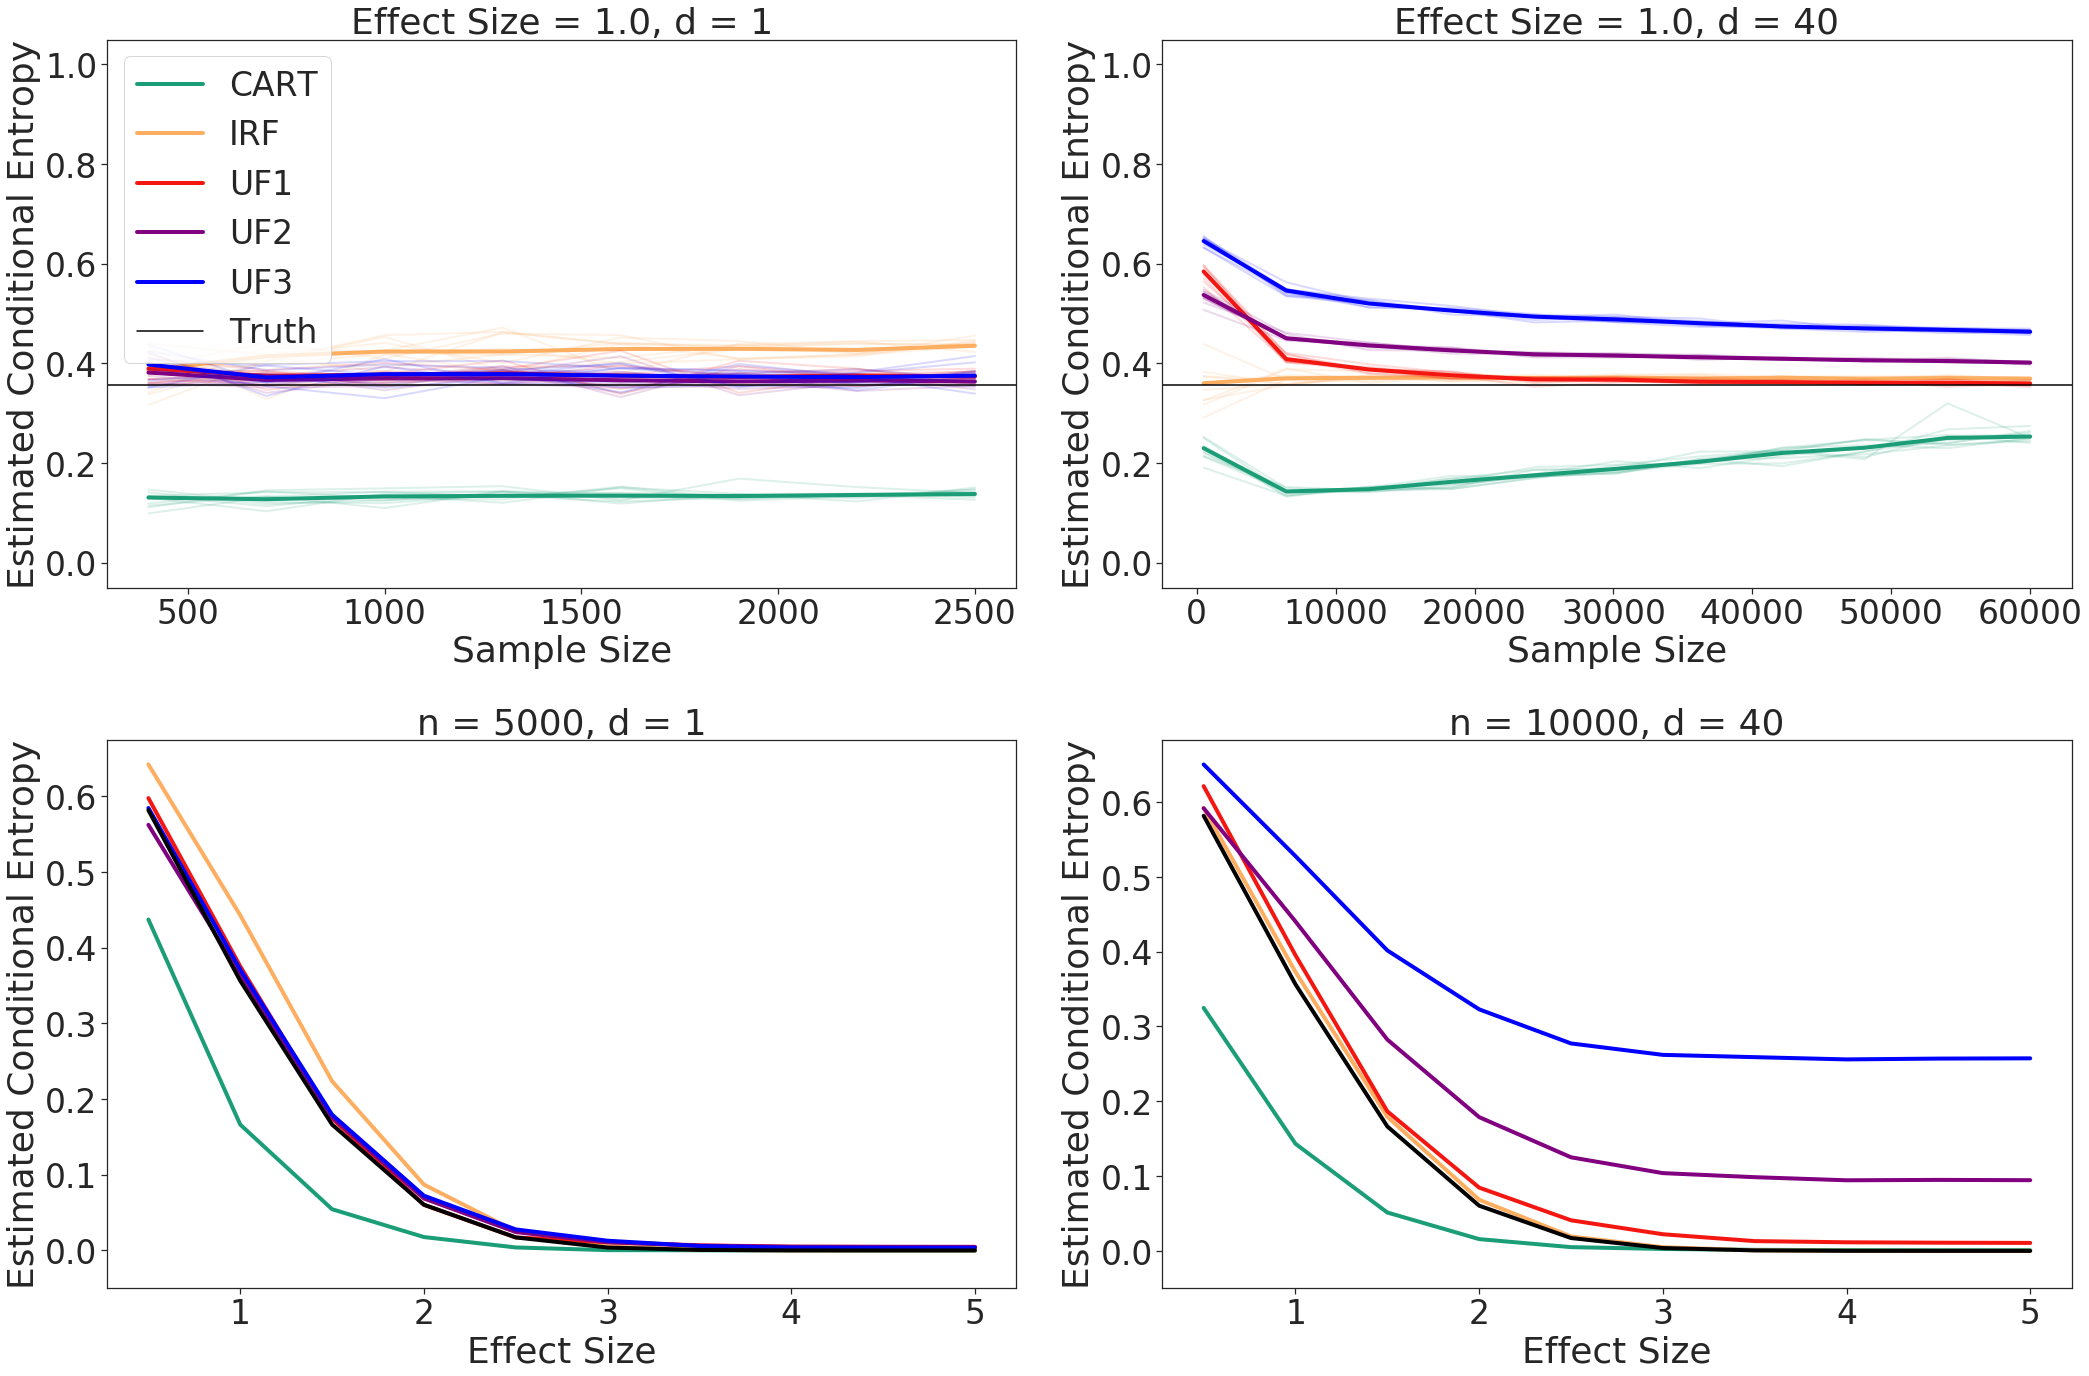

In [24]:
plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos)